# Práctica Final: Clasificación con Scikit-learn y MLflow

En esta práctica, utilizarás un conjunto de datos de Scikit-learn (podeís usar el mismo que en el notebook de Intro MLFlow) para entrenar un modelo de clasificación.

Pasos a seguir: 

    Exploración de Datos: Analiza el conjunto de datos proporcionado para comprender su estructura y contenido.

    Preprocesamiento de Texto: Realiza tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.

    Entrenamiento del Modelo: Utiliza algoritmos de clasificación de Scikit-learn para entrenar un modelo con los datos preprocesados.

    Evaluación del Modelo: Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.

    Registro de Métricas con MLflow: Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.


Nota: Dado que no voy a poder tener acceso a vuestros logs de MLFlow añadirme las imagenes de la interfaz de MLFlow en el notebook

### Solución
Para esta sección de la práctica se va a resolver un problema de pprocesado de lenguaje natural resolviendo un problema de clasificación.

En este caso se ha elegido un dataset conocido denominado "20 Newsgroups" y se va a realizar una clasificación temática. 

Este dataset consta de 20 categorías distintas, pero por simplificar el entrenamiento del modelo vamos a escoger solo 4 categorías para limitar el tamaño del dataset.

La idea es poder registrar y revisar todas las métricas generadas en todo el flujo de estudio del data set. 

Por ello, en primer lugar cargamos las librerías y el dataset. Este dataset es un conjunto de datos de ejemplo que incluye la librería sklearn. 

Carga de librerías y dataset:

In [11]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

from sklearn.datasets import fetch_20newsgroups

Cargamos el dataset y hacemos el split entre datos de train y test. En este caso el dataset ya viene separado en estos subconjuntos.

Nos quedamos tambien con las 4 categorías que hemos mencionado anteriormente:

In [12]:
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

In [13]:
df_train = pd.DataFrame({'text': newsgroups_train.data, 'target': newsgroups_train.target}) 
df_test = pd.DataFrame({'text': newsgroups_test.data, 'target': newsgroups_test.target})
df_train.head()

,text,target
0,From: nigel.allen@canrem.com (Nigel Allen)\nSu...,1
1,From: marshall@csugrad.cs.vt.edu (Kevin Marsha...,0
2,From: tedr@athena.cs.uga.edu (Ted Kalivoda)\nS...,1
3,From: keith@cco.caltech.edu (Keith Allan Schne...,0
4,From: mayne@ds3.scri.fsu.edu (Bill Mayne)\nSub...,1


Viendo el data set parece que son correos electrónicos por lo que habrá bastante información que no nos interese. Por ello, voy a utilizar la librería nltk para limpiar el corpus antes de vectorizar:

In [14]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')

def preprocess_text_nltk(text):
    text = re.sub(r'From:.*\n', '', text)
    text = re.sub(r'Subject:.*\n', '', text)
    text = re.sub(r'Lines:.*\n', '', text)
    text = re.sub(r'To:.*\n', '', text)
    text = re.sub(r'Contact:.*\n', '', text)
    text = re.sub(r'NOTE.*\n', '', text)
    text = re.sub(r'\n---+\n', '', text)
    text = re.sub(r'\d{3}-\d{3}-\d{4}', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) 
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

text = df_train["text"][0]
clean_text = preprocess_text_nltk(text)

print("Texto sin procesar: ", text, "|\n\nTexto procesado: ",clean_text)

Texto sin procesar:  From: nigel.allen@canrem.com (Nigel Allen)
Subject: library of congress to host dead sea scroll symposium april 21-22
Lines: 96


 Library of Congress to Host Dead Sea Scroll Symposium April 21-22
 To: National and Assignment desks, Daybook Editor
 Contact: John Sullivan, 202-707-9216, or Lucy Suddreth, 202-707-9191
          both of the Library of Congress

   WASHINGTON, April 19  -- A symposium on the Dead Sea 
Scrolls will be held at the Library of Congress on Wednesday,
April 21, and Thursday, April 22.  The two-day program, cosponsored
by the library and Baltimore Hebrew University, with additional
support from the Project Judaica Foundation, will be held in the
library's Mumford Room, sixth floor, Madison Building.
   Seating is limited, and admission to any session of the symposium
must be requested in writing (see Note A).
   The symposium will be held one week before the public opening of a
major exhibition, "Scrolls from the Dead Sea: The Ancient Library

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jaime.gonzalez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaime.gonzalez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Una vez realizada la función de preprocesado, la aplicamos a todo el dataset:

In [15]:
df_train['clean_text'] = df_train['text'].apply(preprocess_text_nltk) 
df_test['clean_text'] = df_test['text'].apply(preprocess_text_nltk)

Ahora vectorizamos el corpus:

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizar los textos preprocesados
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['clean_text'])
X_test = vectorizer.transform(df_test['clean_text'])

y_train = df_train['target']
y_test = df_test['target']


Y entrenamos el modelo:

In [17]:
from sklearn.linear_model import LogisticRegression

# Entrenar un modelo de Logistic Regression
model = LogisticRegression(max_iter=400)
model.fit(X_train, y_train)


LogisticRegression(max_iter=400)

Entrenado el modelo, sacamos las métricas más importantes:

In [18]:
from sklearn.metrics import classification_report

# Predicciones y evaluación
predictions = model.predict(X_test)
print(classification_report(y_test, predictions, target_names=categories))


                        precision    recall  f1-score   support

           alt.atheism       0.95      0.73      0.82       319
soc.religion.christian       0.82      0.97      0.89       398

              accuracy                           0.86       717
             macro avg       0.88      0.85      0.85       717
          weighted avg       0.87      0.86      0.86       717



Ahora vamos a registrar las métricas más importantes en MLFlow

In [22]:
from sklearn.metrics import precision_recall_fscore_support

def log_model_metrics(model, X_test, y_test):
    # Evaluar el modelo y registrar las métricas
    accuracy = model.score(X_test, y_test)
    predictions = model.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')

    with mlflow.start_run():
        # Registrar parámetros y métricas
        mlflow.log_param("model", "LogisticRegression")
        mlflow.log_param("vectorizer", "TfidfVectorizer")
        mlflow.log_param("max_iter", 1000)

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)

        # Registrar el modelo entrenado
        mlflow.sklearn.log_model(model, "model")

    print(f"Model accuracy: {accuracy}")
    print(f"Model precision: {precision}")
    print(f"Model recall: {recall}")

log_model_metrics(model, X_test, y_test)

2024/12/16 08:37:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model accuracy: 0.8605299860529986
Model precision: 0.8740771267729843
Model recall: 0.8605299860529986


In [20]:
!mlflow ui

^C


Ahora vamos a acceder al servidor local que hemos montado con el portal web de MLFlow en localhost por el puerto 5000:

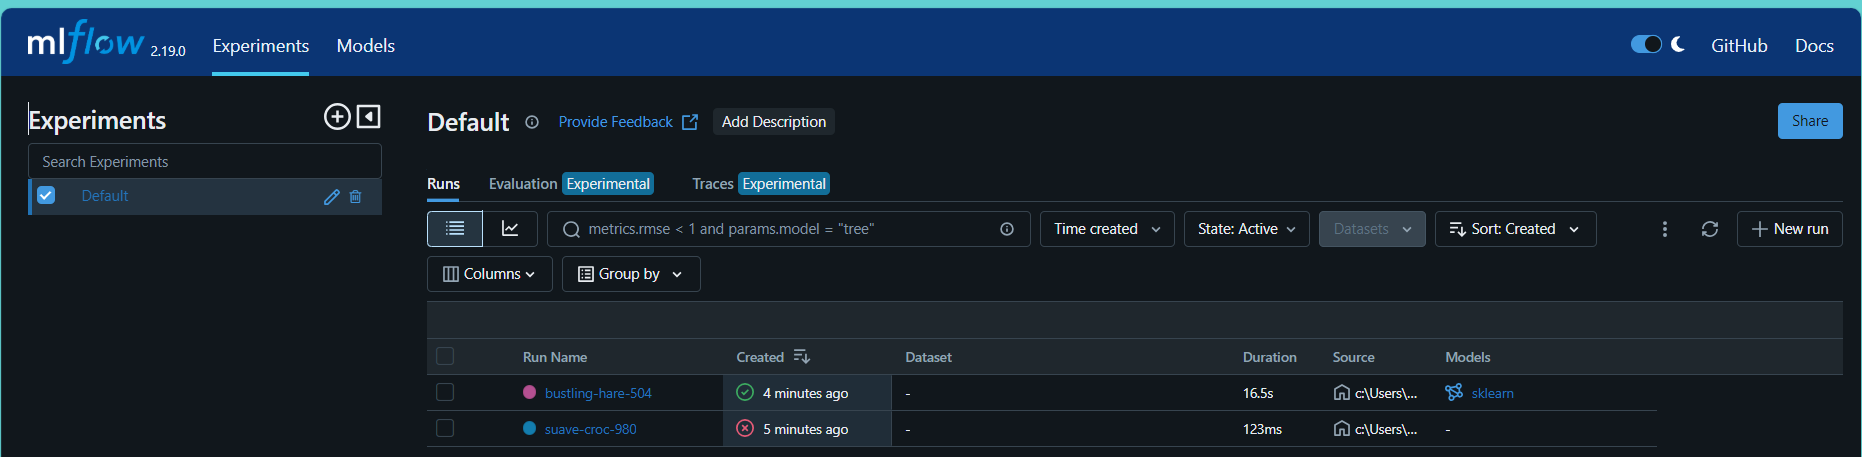

También podemos ver las métricas que hemos registrado:

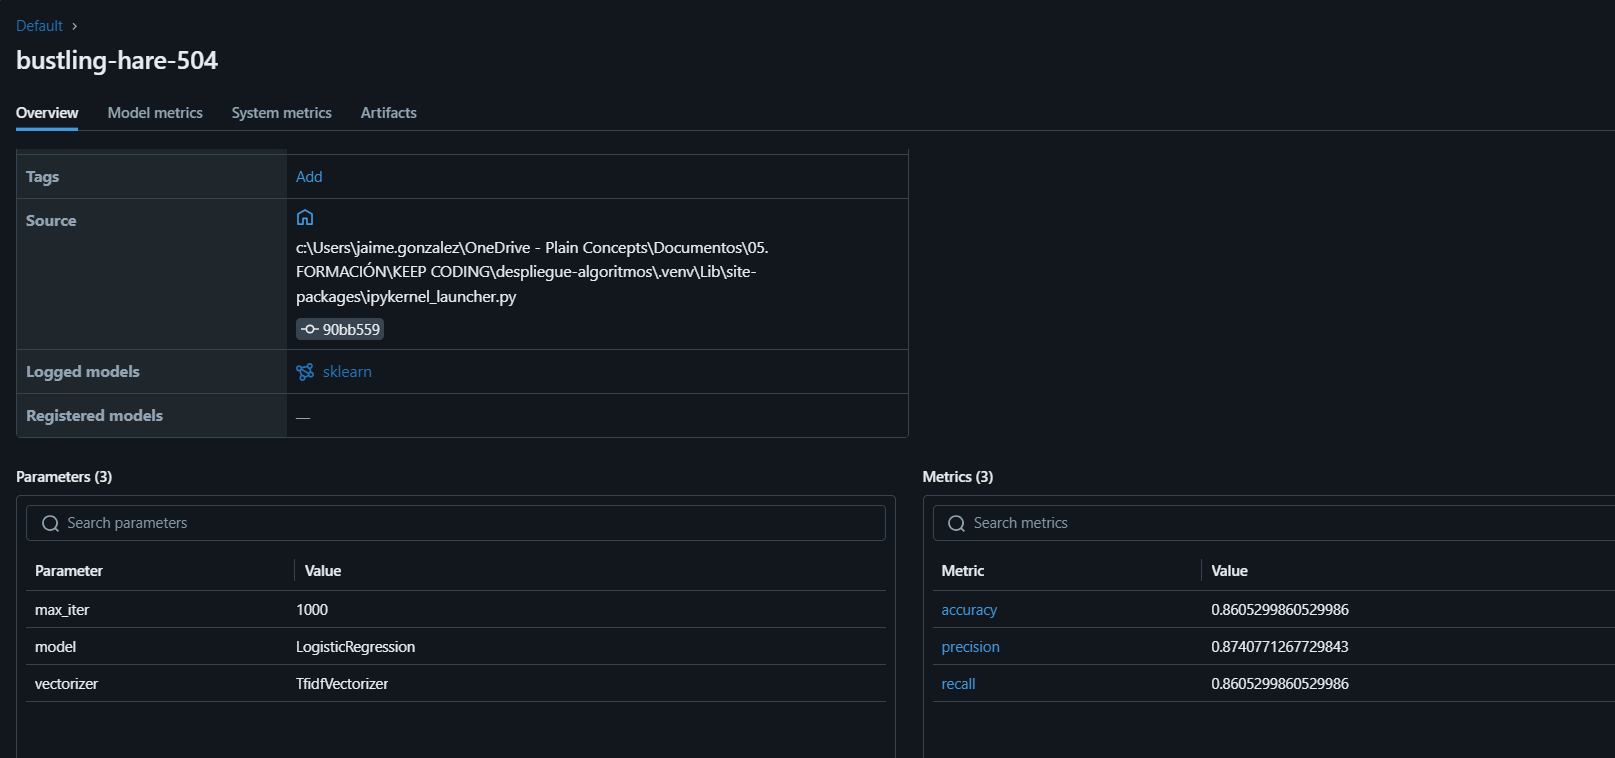

## Generar .py de funciones y main con al menos dos argumentos de entrada.

Para esta parte de la práctica vamos a pasar todo el ejercicio enterior a funciones para tenerlo separado lógicamente y poder reutilizar código en otros modelos. Además crearemos un main para poder ejecutar el modelo desde la terminal y poder automatizar e incluso paquetizar los modelos para entrenarlos en sistemas de microservicios.

funciones.py:

In [ ]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import nltk
import re
import argparse

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

nltk.download('punkt_tab')
nltk.download('stopwords')

def args():
    parser = argparse.ArgumentParser(description='__main__ de la aplicación con argumentos de entrada.')
    parser.add_argument('--max_iter', type=int, help='Máximas iteraciones del modelo')
    parser.add_argument('--categories', nargs='+', type=str, help='Lista de categorías')    
    return parser.parse_args()

def load_dataset(categories):
    #categories = ['alt.atheism', 'soc.religion.christian']
    newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
    newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
    df_train = pd.DataFrame({'text': newsgroups_train.data, 'target': newsgroups_train.target}) 
    df_test = pd.DataFrame({'text': newsgroups_test.data, 'target': newsgroups_test.target})
    return df_train, df_test

def preprocess_text_nltk(text):
    text = re.sub(r'From:.*\n', '', text)
    text = re.sub(r'Subject:.*\n', '', text)
    text = re.sub(r'Lines:.*\n', '', text)
    text = re.sub(r'To:.*\n', '', text)
    text = re.sub(r'Contact:.*\n', '', text)
    text = re.sub(r'NOTE.*\n', '', text)
    text = re.sub(r'\n---+\n', '', text)
    text = re.sub(r'\d{3}-\d{3}-\d{4}', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) 
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

def vectorizer(df_train, df_test):
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(df_train['clean_text'])
    X_test = vectorizer.transform(df_test['clean_text'])
    y_train = df_train['target']
    y_test = df_test['target']
    return X_train, X_test, y_train, y_test

def model_train(X_train, y_train, max_iter):
    model = LogisticRegression(max_iter)
    model.fit(X_train, y_train)
    return model

def log_model_metrics(model, X_test, y_test):
    # Evaluar el modelo y registrar las métricas
    accuracy = model.score(X_test, y_test)
    predictions = model.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')

    with mlflow.start_run():
        # Registrar parámetros y métricas
        mlflow.log_param("model", "LogisticRegression")
        mlflow.log_param("vectorizer", "TfidfVectorizer")
        mlflow.log_param("max_iter", 1000)

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)

        # Registrar el modelo entrenado
        mlflow.sklearn.log_model(model, "model")

main.py:

In [ ]:
from funciones import args,load_dataset,preprocess_text_nltk,vectorizer,model_train,log_model_metrics

def main():
    args_values = args()
    df_train, df_test = load_dataset(args_values.categories)
    df_train['clean_text'] = df_train['text'].apply(preprocess_text_nltk) 
    df_test['clean_text'] = df_test['text'].apply(preprocess_text_nltk)
    X_train, X_test, y_train, y_test = vectorizer(df_train, df_test)
    modelo = model_train(X_train, y_train, args_values.max_iter)
    log_model_metrics(modelo, X_test, y_test)

    if __name__ == '__main__':
        modelo()

Ejecución del modelo desde consola:

In [ ]:
python main.py --max_iter 400 --categories alt.atheism soc.religion.christian

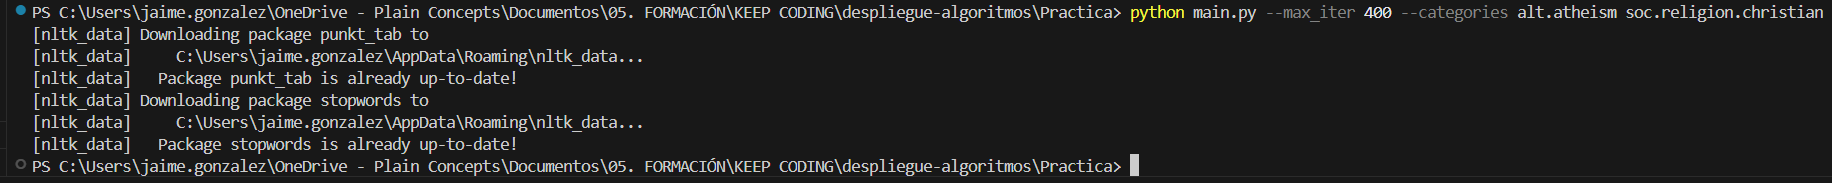

## Práctica parte FastAPI

### Para esta parte de la práctica teneis que generar un script con al menos 5 modulos app.get y dos de ellos tienen que ser pipelines de HF. 

### Parte de la practica se tendra que entregar en capturas de pantalla. Las capturas de pantalla a adjuntas son las siguientes. 

### 1. Captura de la pantalla docs con al menos 5 modulos. 
### 2. Captura de cada una de los modulos con la respuesta dentro de docs. 
### 3. Captura de cada uno de los modulos en la llamada https.
### 4. Todo el codigo usado durante el proceso. Notebooks y scripts.

In [4]:
from fastapi import FastAPI
from pydantic import BaseModel
import base64
import urllib
from typing import Optional
from transformers import pipeline

c:\Users\jaime.gonzalez\OneDrive - Plain Concepts\Documentos\05. FORMACIÓN\KEEP CODING\despliegue-algoritmos\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


A continuación vamos a desarrollar 7 métodos de nuestra API. Se han generado los siguientes métodos:

In [6]:
app = FastAPI()

@app.get("/summarize")
def summarize_text(text: str):
  summarization_pipeline = pipeline("summarization")
  result = summarization_pipeline(text)
  return {"summary": result}

@app.get('/generate_text')
def generate_text(prompt: str): 
    generator = pipeline('text-generation')
    return generator(prompt)

@app.get('/sentiment')
def sentiment_classifier(query): 
    sentiment_pipeline = pipeline('sentiment-analysis')
    return sentiment_pipeline(query)[0]['label']

@app.get('/translate')
def translate_text(text: str): 
    translation_pipeline = pipeline('translation_en_to_de')
    translated_text = translation_pipeline(text)
    return {'Translated Text': translated_text[0]['translation_text']}

@app.get("/add")
def add(n1: float, n2: float):
  return {"Result": n1+n2}

@app.get('/url_encode')
def encode_url(text: str):
    encoded_url = urllib.parse.quote(text)
    return {'Encoded URL': encoded_url}

@app.get('/url_decode')
def decode_url(encoded_text: str):
    decoded_url = urllib.parse.unquote(encoded_text)
    return {'Decoded URL': decoded_url}

Publicamos:

In [12]:
import nest_asyncio
from pyngrok import ngrok, conf
NGROK_TOKEN = "" #Se ha eliminado el token para no subirlo al repositorio
conf.get_default().auth_token = NGROK_TOKEN

ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()

Public URL: https://c597-2a0c-5a81-c407-5c01-00-39a4.ngrok-free.app


Esta es la URL asignada en Ngrok: [https://c501-2a0c-5a81-c407-5c01-00-39a4.ngrok-free.app    ](https://c597-2a0c-5a81-c407-5c01-00-39a4.ngrok-free.app)

Lo que estamos configurando es un servidor WEB que expone un portal de administración de API, mostrando todos los métodos desarrollados. Este servidor se monta en local sobre el puerto 8000 con uvicorn, de hecho podemos acceder a la misma página en localhost:8000. La gracia es que con Ngrok podemos crear un túnel gratuito entre el servidor WEB de Ngrok y nuestro servidor local, pudiendo exponer nuestra API de forma gratuita y segura.

In [13]:
! uvicorn practica_fastapi:app --port 8000

INFO:     Started server process [27084]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 10048] error while attempting to bind on address ('127.0.0.1', 8000): [winerror 10048] solo se permite un uso de cada dirección de socket (protocolo/dirección de red/puerto)
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.


### FastAPI:

/docs:
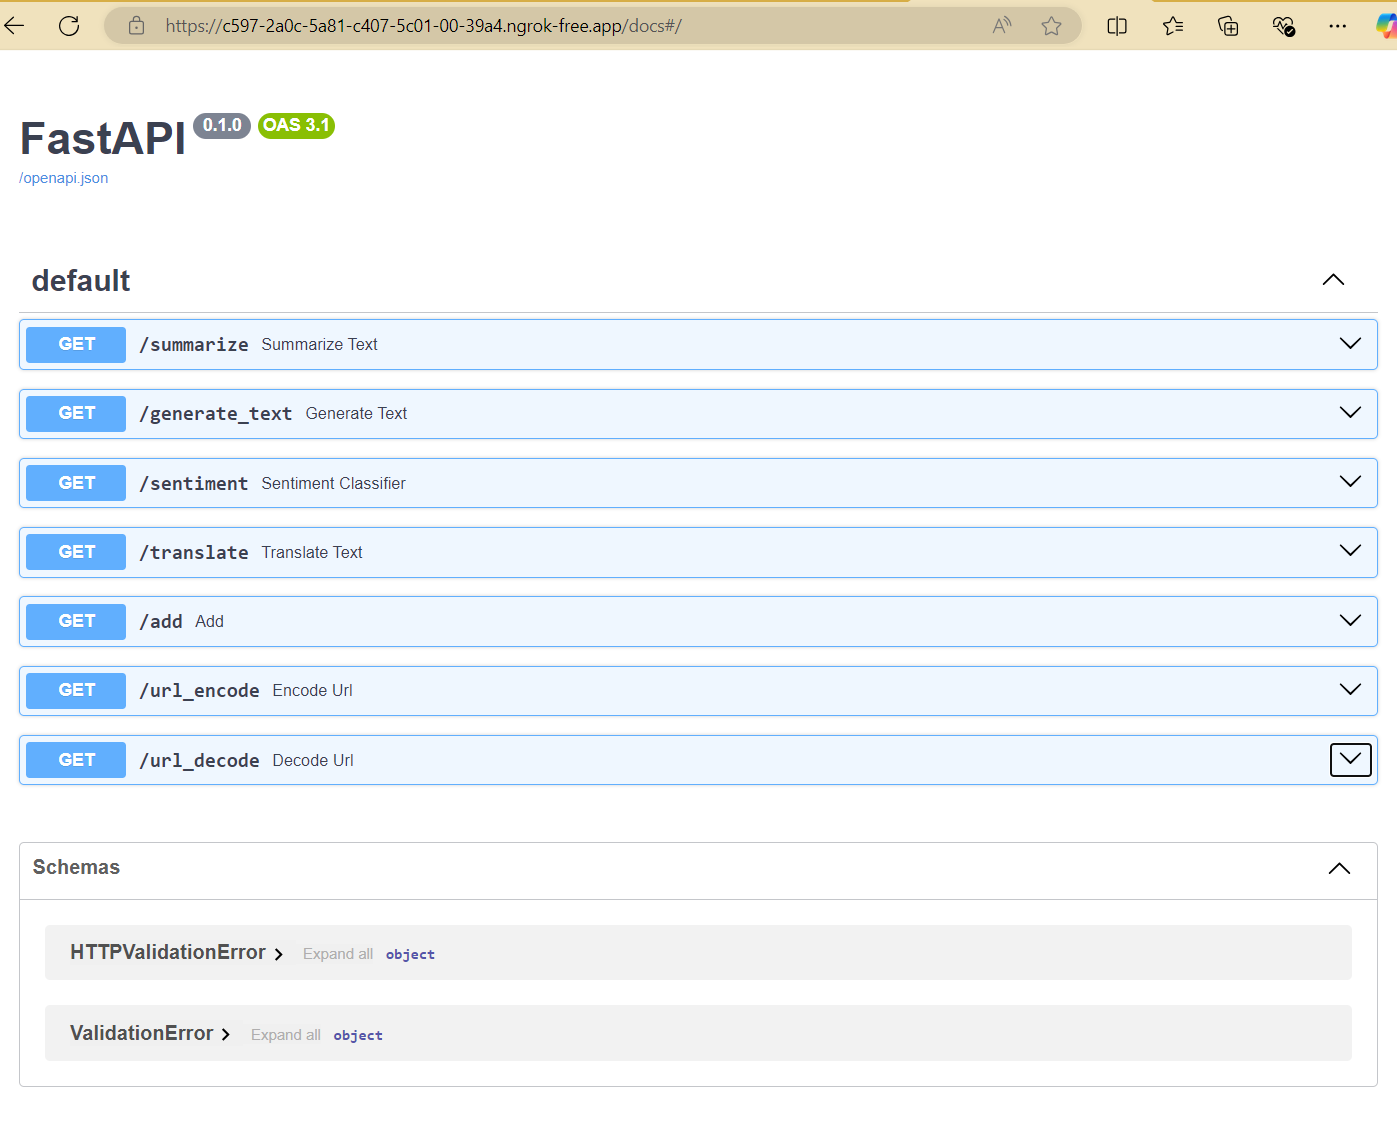

/summarize

Texto original:
El desarrollo tecnológico ha transformado la manera en que las personas se comunican, trabajan y acceden a la información. La invención de Internet y la popularización de dispositivos inteligentes han permitido la conexión global, facilitando el intercambio instantáneo de datos y conocimientos. Sin embargo, esta evolución también ha traído desafíos significativos, como la dependencia excesiva de la tecnología, la disminución de la privacidad y la proliferación de información falsa. Las redes sociales, por ejemplo, permiten conectar a millones de personas, pero también pueden propagar noticias falsas rápidamente. Además, el uso constante de dispositivos electrónicos ha generado problemas de salud, como fatiga visual y adicción a las pantallas. A pesar de estos inconvenientes, la tecnología continúa avanzando, y su adopción responsable es clave para aprovechar sus beneficios sin comprometer el bienestar humano.

Texto resumido: 
El desarrollo tecnológico ha transformado la manera en que personas se comunican, trabajan y acceden a la información . La invención de Internet y the popularización of dispositivos inteligentes han permitido la conexión global.
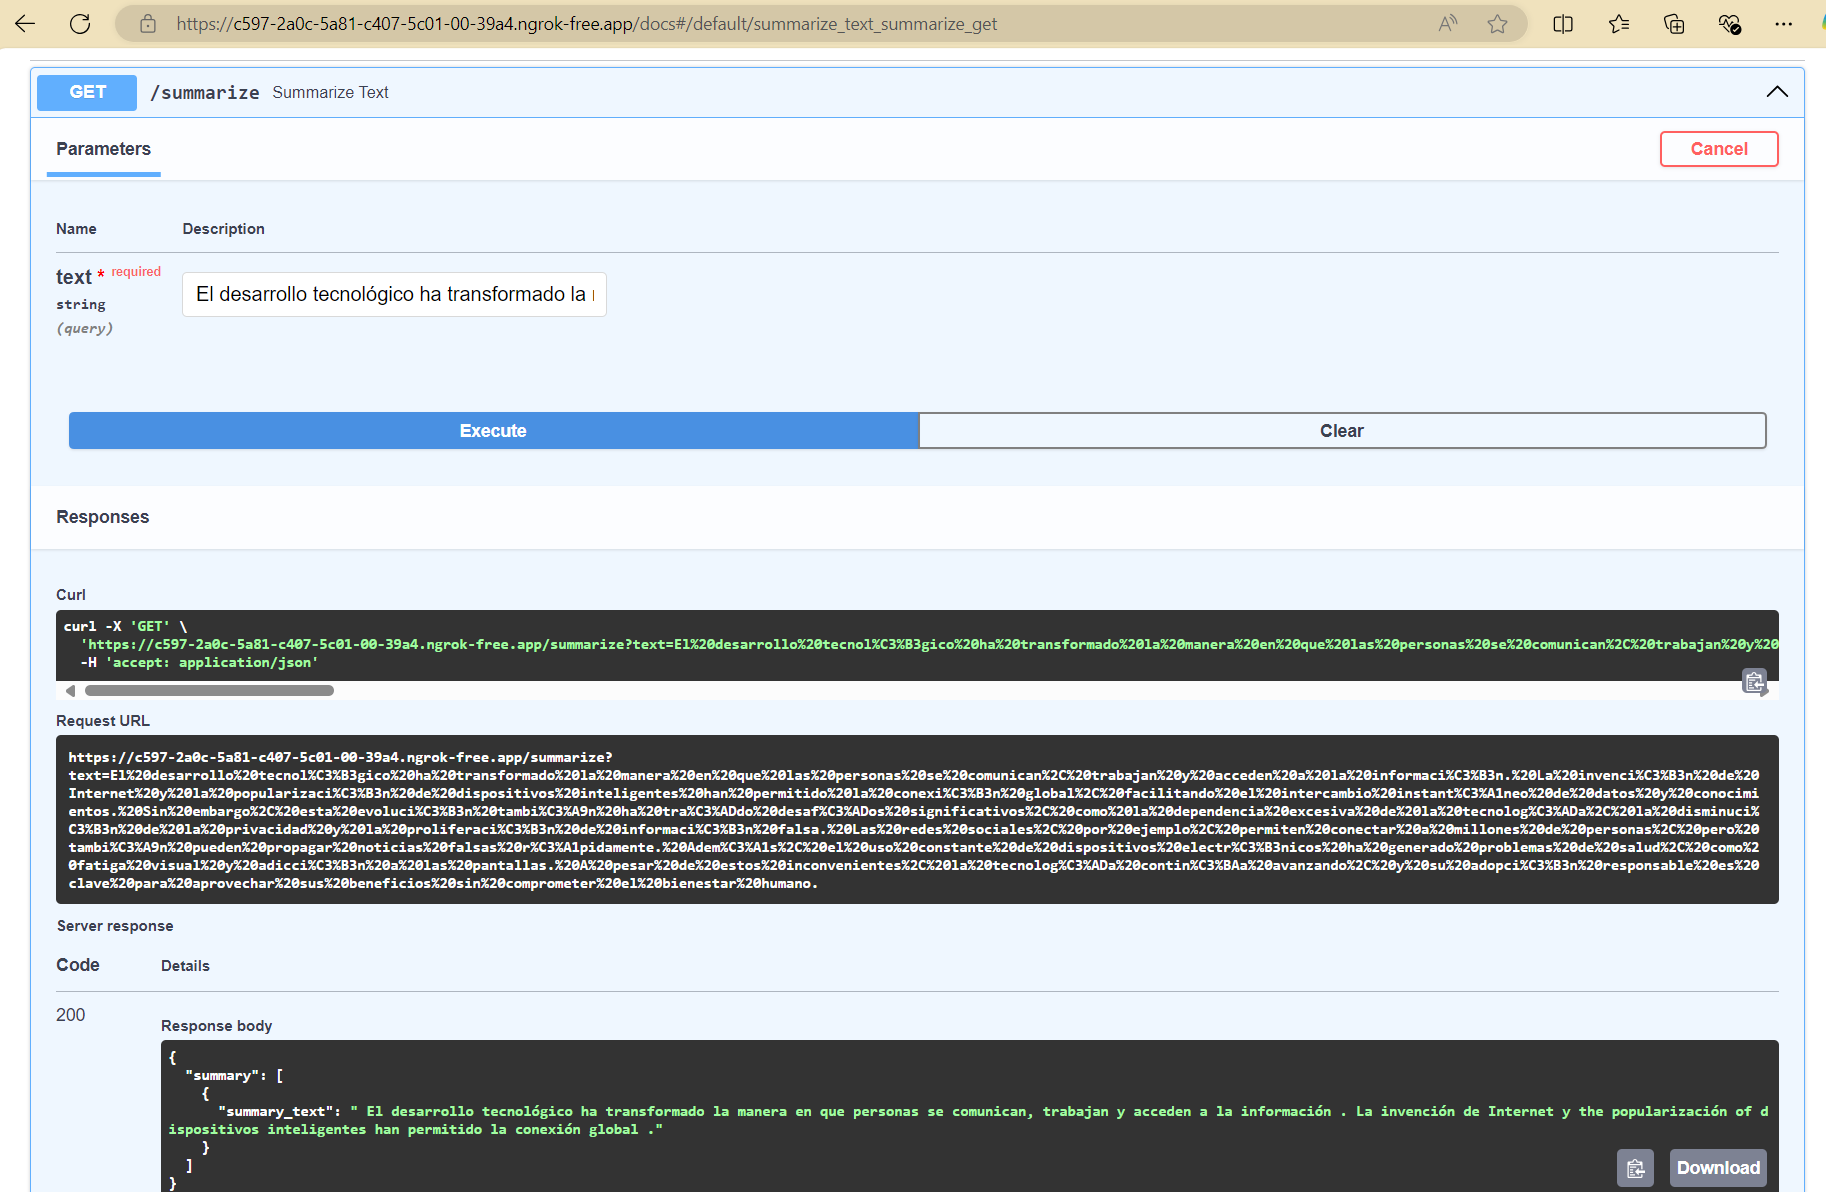

/generate_text

Prompt:
hola

Texto generado:
hola. A new study, which was published in BMC Medicine, found that when mice were exposed to an active diet of high-fat and low-carbohydrate dairy proteins, but not to dairy proteins containing no lactose, their brains were better
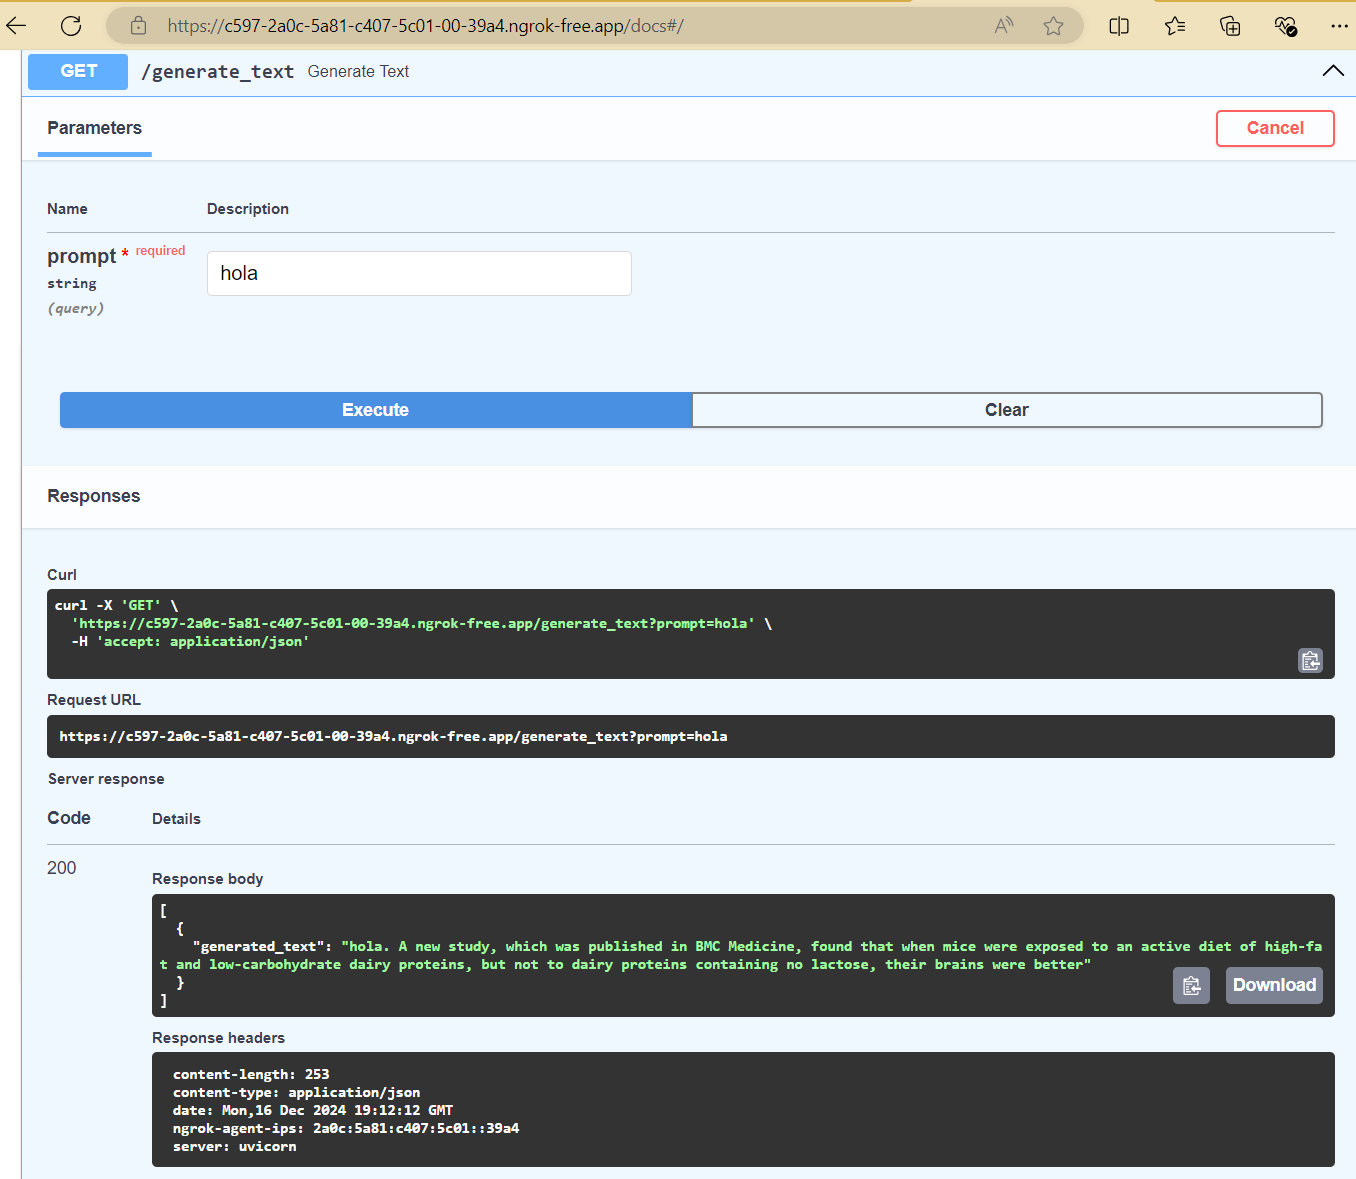

/sentiment

Prompt:
La experiencia en el restaurante fue terrible. La comida llegó fría, el servicio fue lento y el lugar estaba muy sucio. No volveré nunca más.

Respuesta:
NEGATIVE
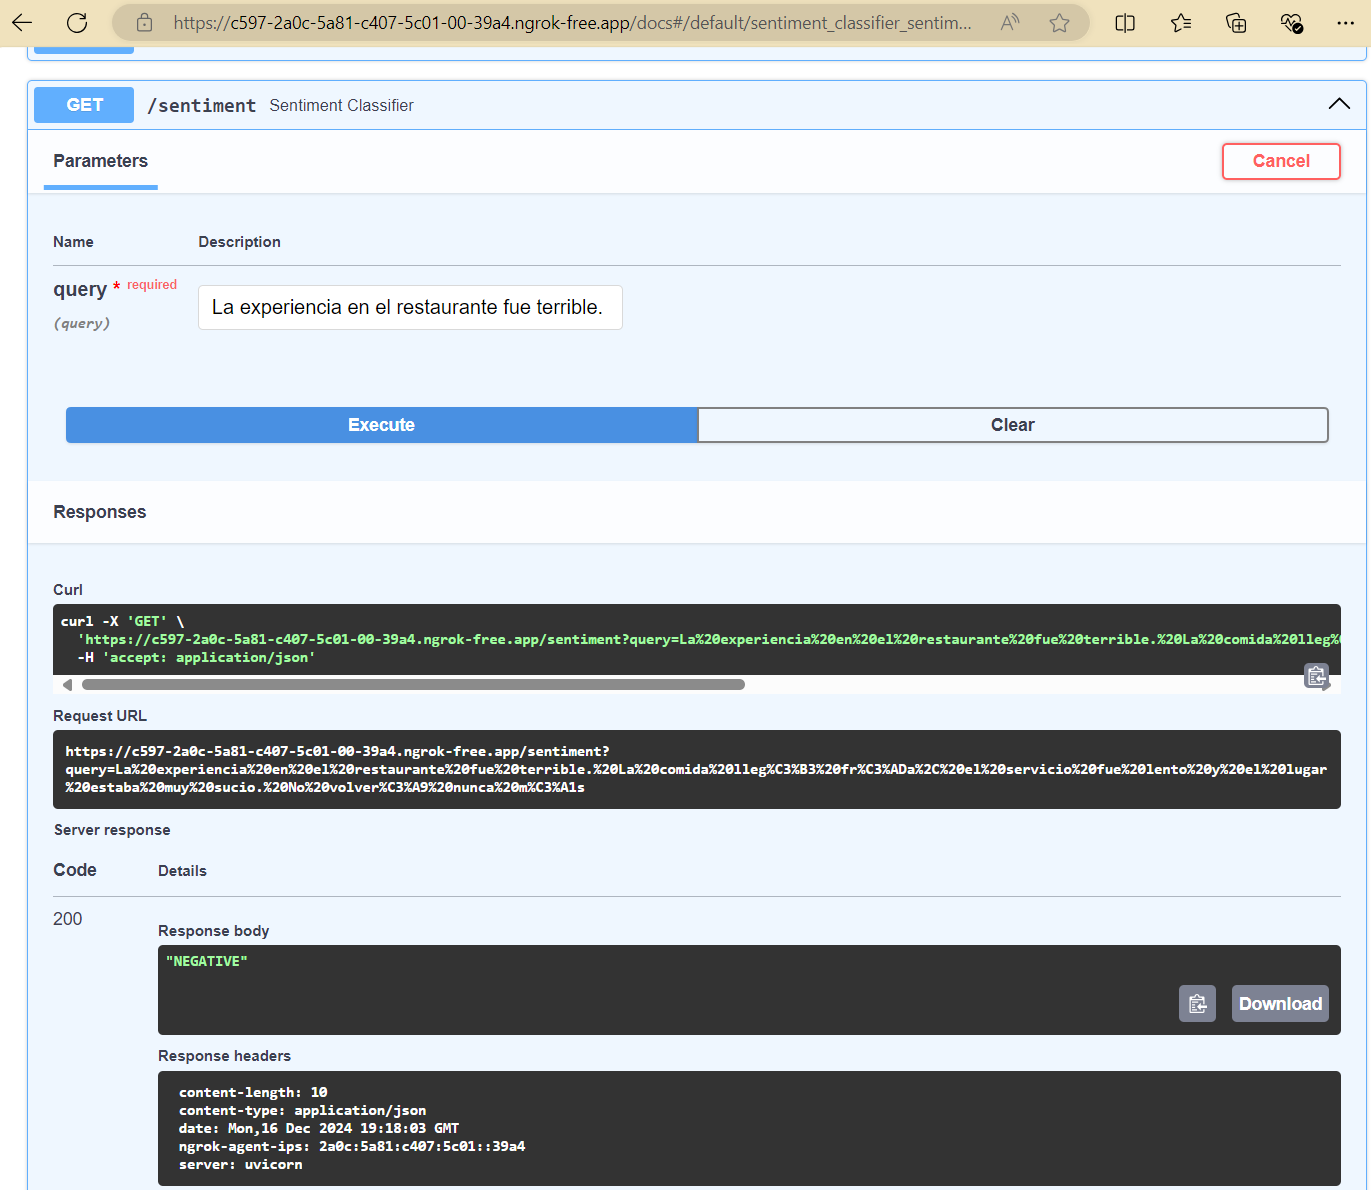

/translate

Prompt:
The weather today is beautiful, and I feel like going for a walk in the park.

Respuesta:
Das Wetter heute ist schön, und ich fühle mich wie einen Spaziergang in den Park.
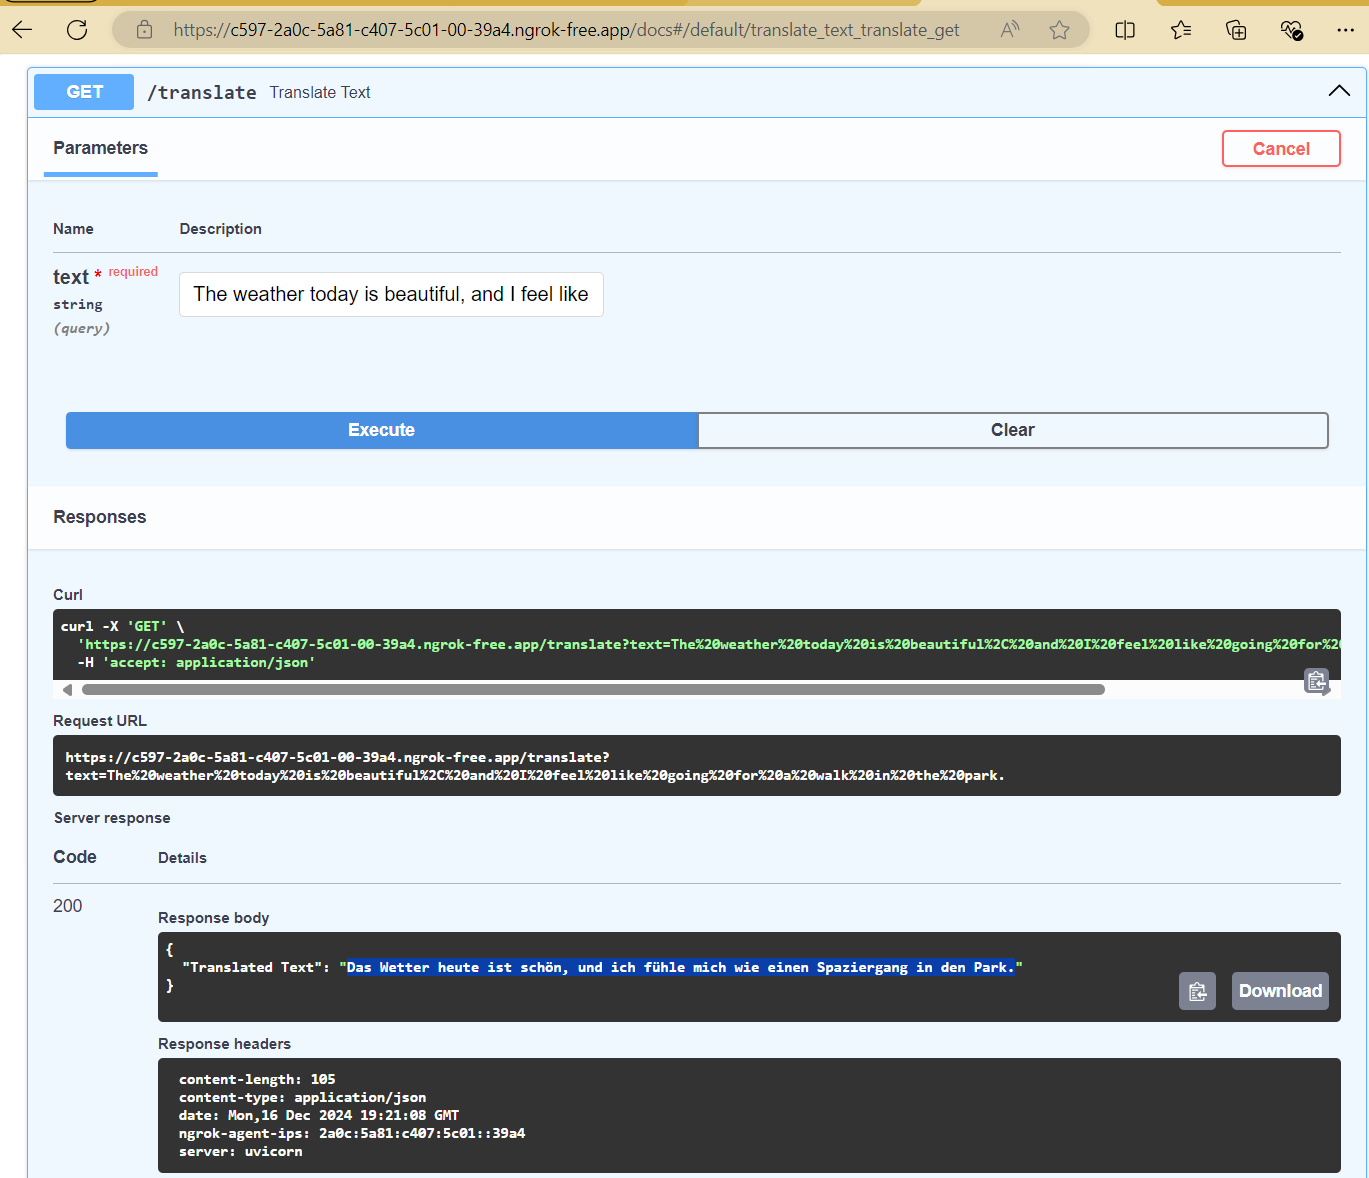

Por seguir haciendo pruebas hice 3 métodos más que no utilizan modelos de hugging face:

/add
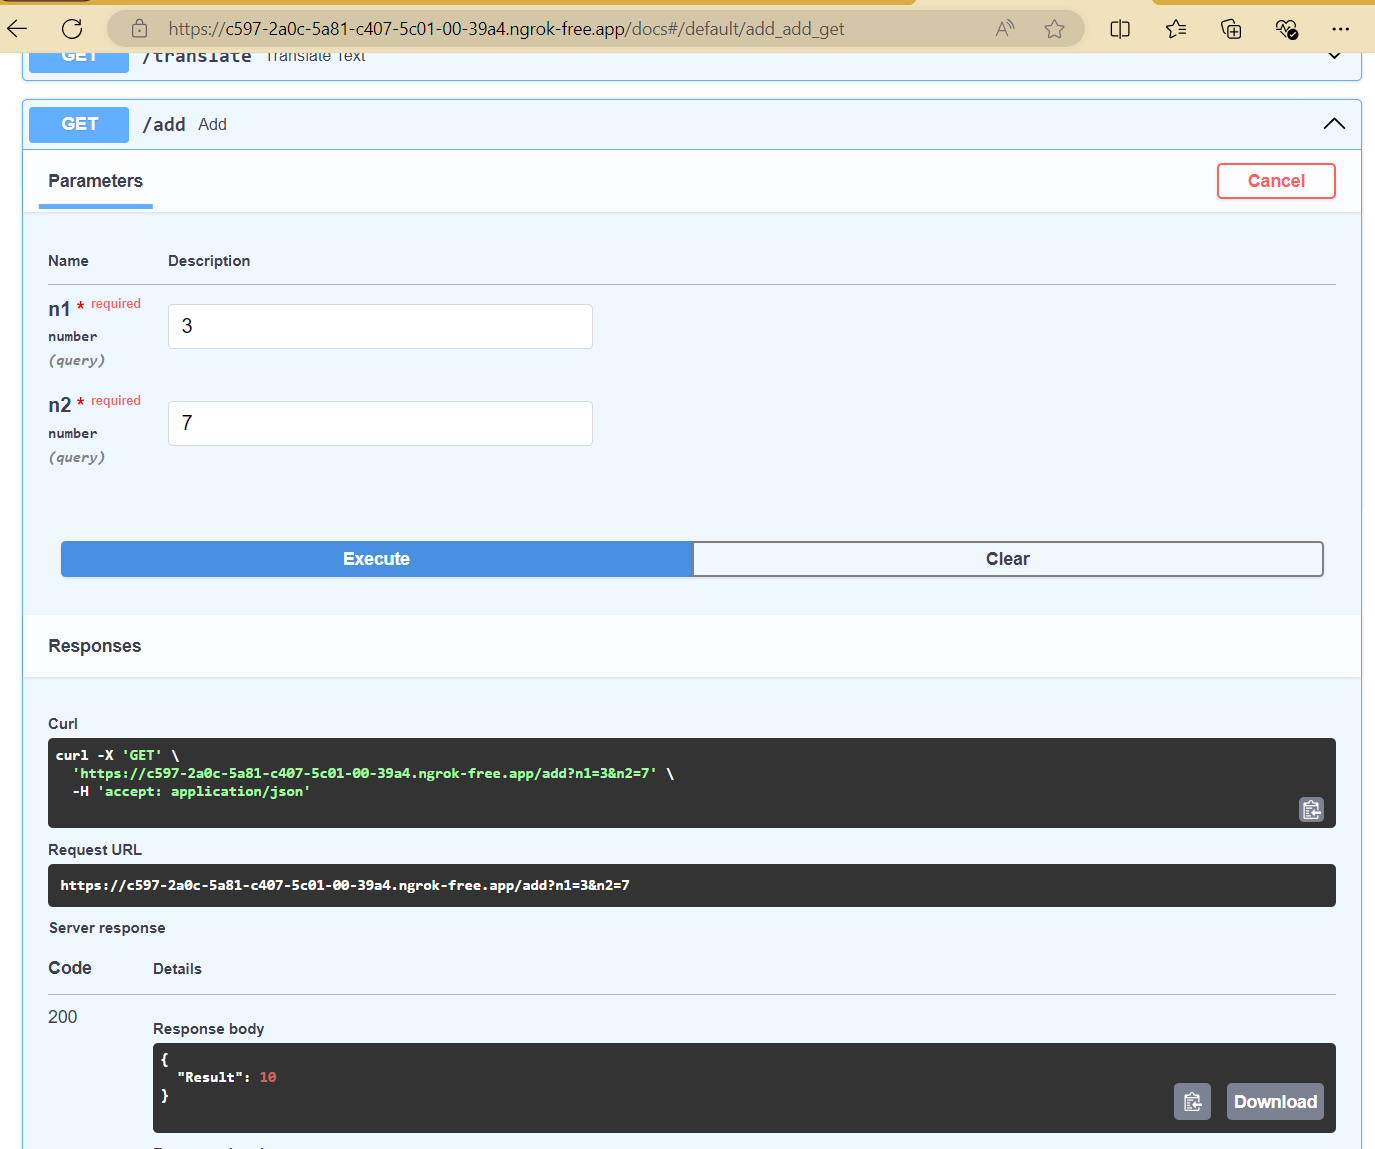

/url_encode

Prompt:
Hello, how are you? Let's meet at 5:00 PM at the park.

Respuesta:
Hello%2C%20how%20are%20you%3F%20Let%27s%20meet%20at%205%3A00%20PM%20at%20the%20park.
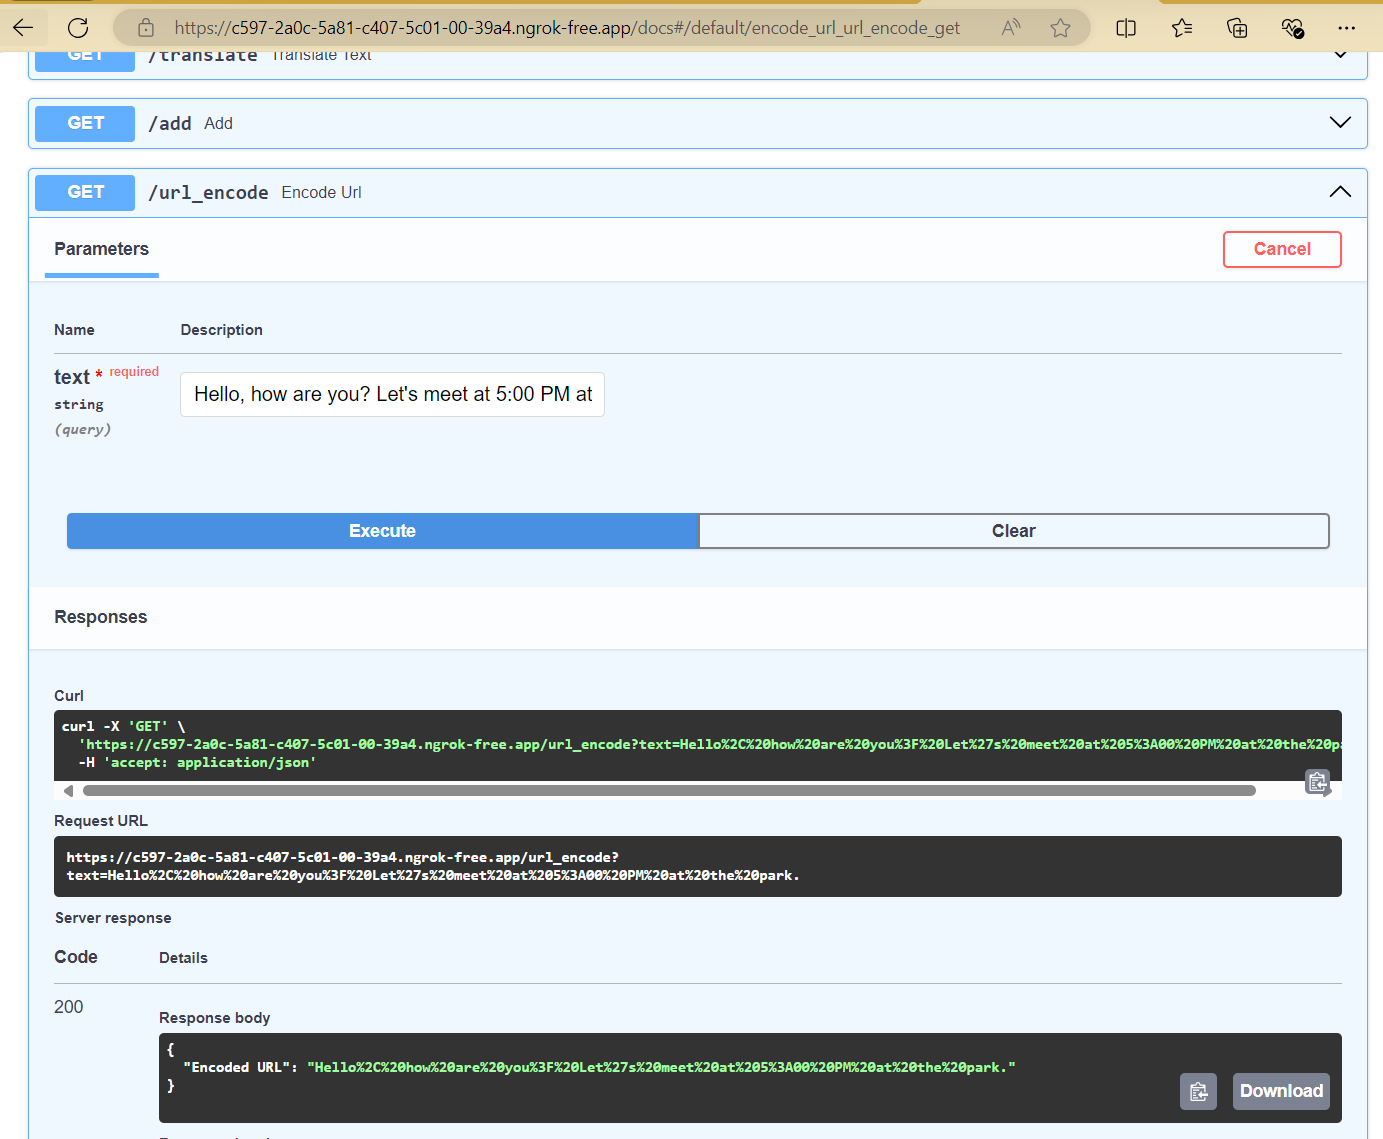

/url_decoder

Prompt:
Hello%2C%20how%20are%20you%3F%20Let%27s%20meet%20at%205%3A00%20PM%20at%20the%20park.

Respuesta:
Hello, how are you? Let's meet at 5:00 PM at the park.
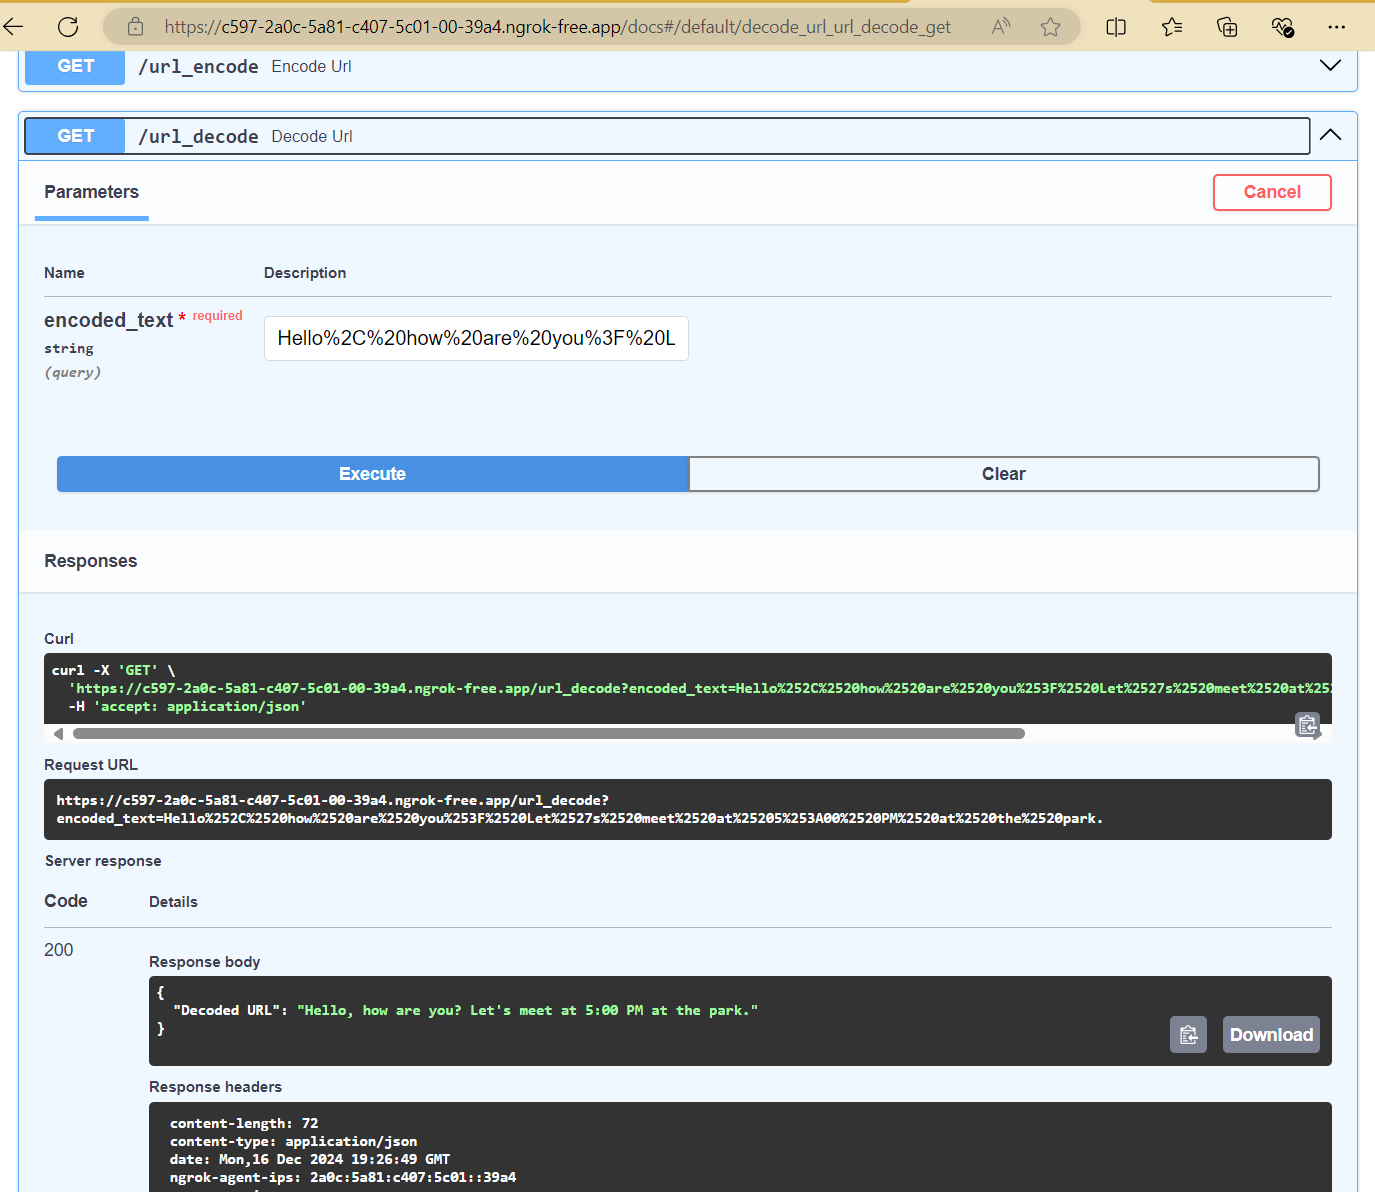